In [9]:
!pip install scikit-learn numpy matplotlib seaborn -q

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # For 2D visualization

# Set Seaborn style for crisp visuals
sns.set(style="whitegrid")


In [10]:
# Load dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target  # Binary: 0=malignant, 1=benign

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For 2D visualization: Reduce to 2 principal components
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

print(f"Training samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")


Training samples: 455 | Test samples: 114


In [11]:
# Linear Kernel SVM
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_scaled, y_train)

# RBF Kernel SVM
svm_rbf = SVC(kernel='rbf', random_state=42)  # Default gamma='scale'
svm_rbf.fit(X_train_scaled, y_train)

# Quick predictions
y_pred_linear = svm_linear.predict(X_test_scaled)
y_pred_rbf = svm_rbf.predict(X_test_scaled)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_linear))
print("RBF SVM Accuracy:", accuracy_score(y_test, y_pred_rbf))


Linear SVM Accuracy: 0.956140350877193
RBF SVM Accuracy: 0.9824561403508771


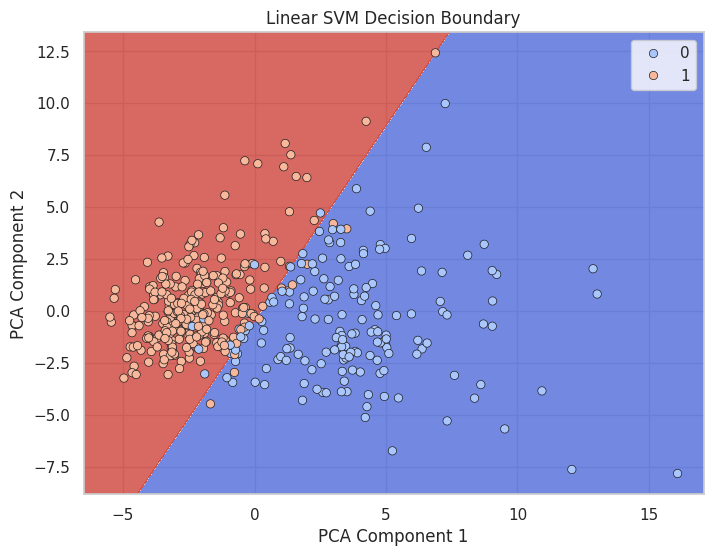

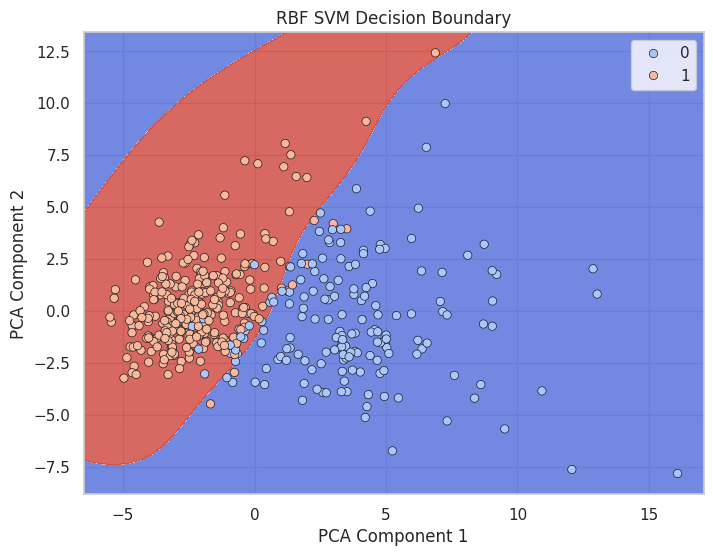

In [12]:
# Function to plot decision boundary
def plot_svm_boundary(model, X, y, title):
    plt.figure(figsize=(8, 6))
    # Create meshgrid for boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Train SVMs on 2D data for plotting
svm_linear_2d = SVC(kernel='linear').fit(X_train_2d, y_train)
svm_rbf_2d = SVC(kernel='rbf').fit(X_train_2d, y_train)

# Plots
plot_svm_boundary(svm_linear_2d, X_train_2d, y_train, 'Linear SVM Decision Boundary')
plot_svm_boundary(svm_rbf_2d, X_train_2d, y_train, 'RBF SVM Decision Boundary')


Best Params: {'C': 10, 'gamma': 0.01}
CV Accuracy Mean: 0.9714285714285715
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



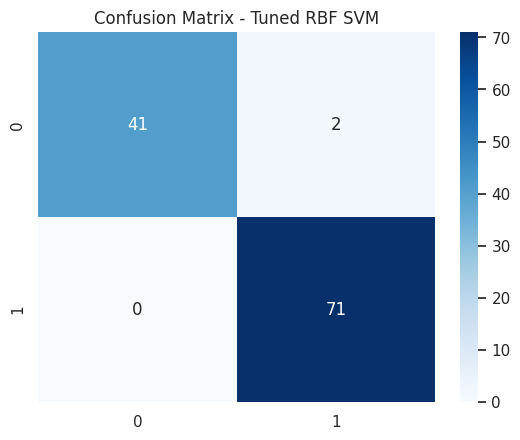

In [13]:
# Param grid
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}

# Grid search with 5-fold CV
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_svm = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# Cross-validation scores
cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=5)
print("CV Accuracy Mean:", cv_scores.mean())

# Test on holdout
y_pred_best = best_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred_best))

# Extra: Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - Tuned RBF SVM')
plt.show()


In [14]:
# Support vectors count
print("Support Vectors (Tuned RBF):", len(best_svm.support_))

# Save model (for repo)
import joblib
joblib.dump(best_svm, 'svm_model.pkl')

# Export predictions to CSV
import pandas as pd
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best}).to_csv('predictions.csv', index=False)

print("Task complete! Model saved as svm_model.pkl | Predictions in predictions.csv")


Support Vectors (Tuned RBF): 59
Task complete! Model saved as svm_model.pkl | Predictions in predictions.csv


In [18]:
df1 = pd.read_csv("predictions.csv")
df1.head()

,Actual,Predicted
0,1,1
1,0,0
2,0,0
3,1,1
4,1,1
